# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

import time
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import xgboost as xgb

# Metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

#from sklearn import preprocessing
#from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV

# Import prepared dataframes

In [2]:
# Bitcoin
df_btc = pd.read_csv('df_btc.csv')
df_btc.Date = pd.to_datetime(df_btc.Date)

# Twitter
df_tw = pd.read_csv('df_tw_agg.csv')
df_tw.Date = pd.to_datetime(df_tw.Date)

In [3]:
list(df_tw.columns)

['Date',
 'tw_neg_sum',
 'tw_neg_mean',
 'tw_neg_std',
 'tw_pos_sum',
 'tw_pos_mean',
 'tw_pos_std',
 'tw_comp_sum',
 'tw_comp_mean',
 'tw_comp_std',
 'tw_RelDiffPosNeg_sum',
 'tw_RelDiffPosNeg_mean',
 'tw_RelDiffPosNeg_std',
 'tw_Like_Count_sum',
 'tw_Like_Count_mean',
 'tw_Like_Count_std',
 'tw_Reply_Count_sum',
 'tw_Reply_Count_mean',
 'tw_Reply_Count_std',
 'tw_Retweet_Count_sum',
 'tw_Retweet_Count_mean',
 'tw_Retweet_Count_std',
 'tw_Quote_Count_sum',
 'tw_Quote_Count_mean',
 'tw_Quote_Count_std',
 'tw_comp_q5_count',
 'tw_comp_q4_count',
 'tw_comp_q3_count',
 'tw_comp_q2_count',
 'tw_comp_q1_count',
 'tw_N',
 'tw_N_pos',
 'tw_N_neg',
 'tw_topic1_freq',
 'tw_topic2_freq',
 'tw_topic3_freq',
 'MrBeast',
 'theestallion',
 'elonmusk',
 'tw_neg_sum_last5_mean',
 'tw_neg_sum_last5_std',
 'tw_neg_sum_last10_mean',
 'tw_neg_sum_last10_std',
 'tw_pos_sum_last5_mean',
 'tw_pos_sum_last5_std',
 'tw_pos_sum_last10_mean',
 'tw_pos_sum_last10_std',
 'tw_comp_sum_last5_mean',
 'tw_comp_sum_las

# Construct the analysis dataframe

### Select the Twitter variables to be used

In [4]:
variables = ['Date',
 'tw_neg_sum',
 'tw_neg_mean',
 'tw_neg_std',
 'tw_pos_sum',
 'tw_pos_mean',
 'tw_pos_std',
 'tw_comp_sum',
 'tw_comp_mean',
 'tw_comp_std',
 'tw_RelDiffPosNeg_sum',
 'tw_RelDiffPosNeg_mean',
 'tw_RelDiffPosNeg_std',
 'tw_Like_Count_sum',
 'tw_Like_Count_mean',
 'tw_Like_Count_std',
 'tw_Reply_Count_sum',
 'tw_Reply_Count_mean',
 'tw_Reply_Count_std',
 'tw_Retweet_Count_sum',
 'tw_Retweet_Count_mean',
 'tw_Retweet_Count_std',
 'tw_Quote_Count_sum',
 'tw_Quote_Count_mean',
 'tw_Quote_Count_std',
 'tw_comp_q5_count',
 'tw_comp_q4_count',
 'tw_comp_q3_count',
 'tw_comp_q2_count',
 'tw_comp_q1_count',
 'tw_N',
 'tw_N_pos',
 'tw_N_neg',
'MrBeast',
 'theestallion',
 'elonmusk']

### Merge Bitcoin and Twitter dataframes

In [5]:
# Apply selection on the BTC dataframe
df_ana = df_btc[(df_btc.Date >= pd.to_datetime('01-04-2020', format='%d-%m-%Y')) & \
       (df_btc.Date < pd.to_datetime('15-03-2021', format='%d-%m-%Y'))]
#df_ana = df_ana[['Date', 'Close', 'Close_next1', 'Close_diff_next1', 'Close_diff_next1_rel', 'Close_diff_next1_sgn']]
df_ana = df_ana.dropna()

# Merge with TW dataframe
df_ana = pd.merge(left=df_ana, right=df_tw[variables], how='inner', left_on='Date', right_on='Date')
df_ana.dropna(inplace=True)

### Study correlations among features

<AxesSubplot:>

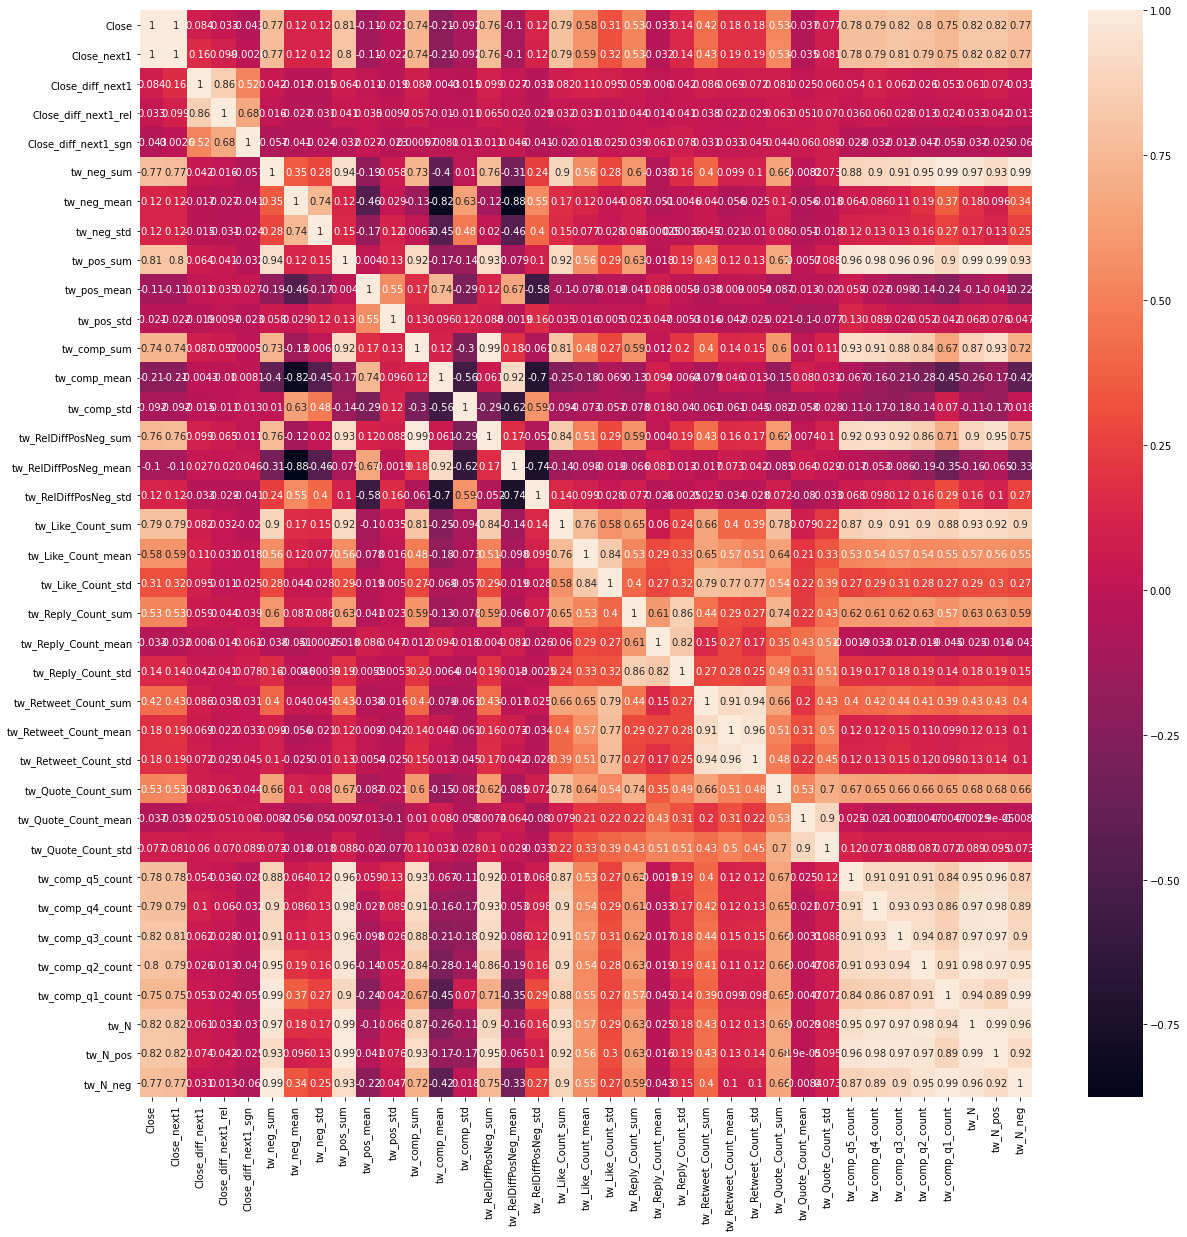

In [11]:
corr = df_ana.corr()
plt.figure(figsize = (20,20))
sb.heatmap(corr,annot=True)

# Modelling

## Target: next day's Bitcoin Close price

### Prepare training and testing datasets

In [7]:
# Define target and input variables
target = 'Close_next1'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_test.sort_values(by=['Date'], inplace=True)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [8]:
model = xgb.XGBRegressor(n_estimators = 1000,\
                        learning_rate = 0.01,\
                        max_depth = 5,\
                        min_split_loss = 10,\
                        min_child_weight = 1,\
                        colsample_bytree = 0.7,\
                        subsample = 0.5,\
                        reg_lambda = 2,\
                        reg_alpha = 0)

#model.fit(X_train_tmp.drop(columns=['Date']),y_train)
model.fit(X_train_tmp,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_split_loss=10, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=2,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Compute extra features for performance evaluation

In [9]:
y_pred=model.predict(X_test_tmp)
X_test['Pred_next1'] = list(y_pred)
X_test['Pred_diff_next1'] = (X_test.Pred_next1 - X_test.Close).to_list()
X_test['Pred_diff_next1_rel'] = (X_test.Pred_diff_next1/X_test.Close).to_list()
X_test['Pred_diff_next1_sgn'] = np.sign(X_test.Pred_diff_next1)

<ipython-input-9-e9ddb46e0ea7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_next1'] = list(y_pred)
<ipython-input-9-e9ddb46e0ea7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1'] = (X_test.Pred_next1 - X_test.Close).to_list()
<ipython-input-9-e9ddb46e0ea7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

### Performance evaluation

In [10]:
print('==================================================================================')
print('Performance on the target variable: next day\'s BTC Close price' )
test = X_test['Close_next1']
pred = X_test['Pred_next1']
print('+++ Next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the absolute diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1']
pred = X_test['Pred_diff_next1']
print('+++ Diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the relative diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_rel']
pred = X_test['Pred_diff_next1_rel']
print('+++ Relative diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_sgn']
pred = X_test['Pred_diff_next1_sgn']
print('+++ Next day BTC price')
print(f"Accuracy:    {accuracy_score(test, pred)}")

Performance on the target variable: next day's BTC Close price
+++ Next day BTC price
Explained variance:    0.723603943288214
R2:                    0.7224948834374783
MAE:                   3215.1907503432835
MSE:                   40079237.09522108

Performance on the absolute diff between today's and next day's BTC Close price
+++ Diff to next day BTC price
Explained variance:    -48.926202733095444
R2:                    -49.126535355817005
MAE:                   3215.1907503432835
MSE:                   40079237.09522108

Performance on the relative diff between today's and next day's BTC Close price
+++ Relative diff to next day BTC price
Explained variance:    -78.84683700322103
R2:                    -951.8713792053757
MAE:                   0.9680187509326184
MSE:                   0.9820207207879619

Performance on the signed diff between today's and next day's BTC Close price
+++ Next day BTC price
Accuracy:    0.43283582089552236


### Plot predictions

<ipython-input-11-c9312ce135ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.sort_values(by=['Date'], inplace=True)


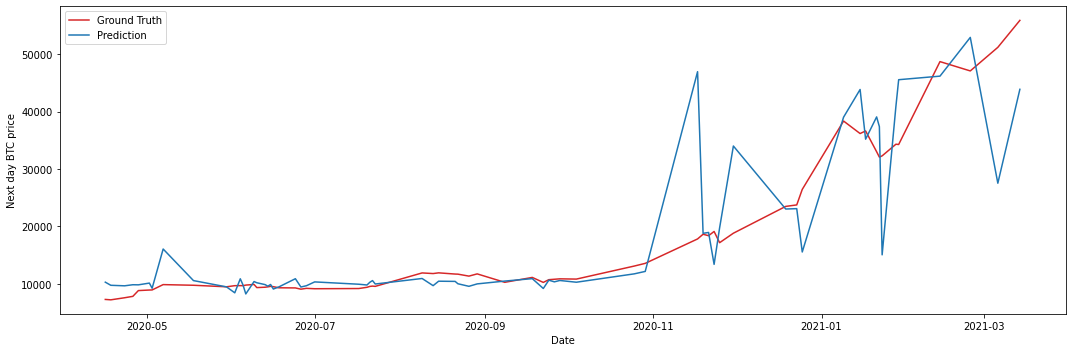

In [11]:
# Next day's BTC price

X_test.sort_values(by=['Date'], inplace=True)
x = X_test.Date
y_test = X_test['Close_next1']
y_pred = X_test['Pred_next1']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Next day BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

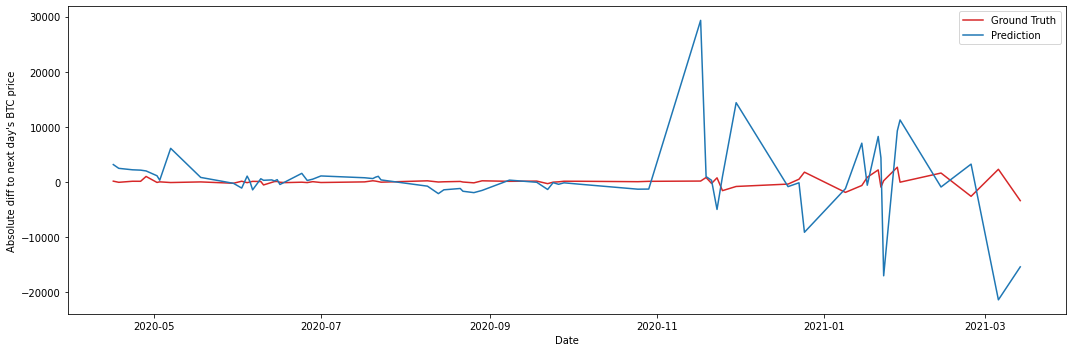

In [12]:
# Absolute diff to next day's BTC price

x = X_test.Date
y_test = X_test['Close_diff_next1']
y_pred = X_test['Pred_diff_next1']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Absolute diff to next day\'s BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

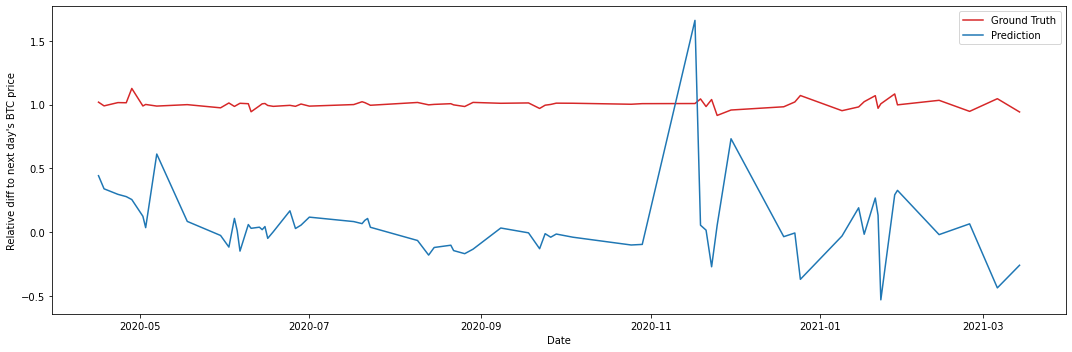

In [13]:
# Relative diff to next day's BTC price

x = X_test.Date
y_test = X_test['Close_diff_next1_rel']
y_pred = X_test['Pred_diff_next1_rel']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Relative diff to next day\'s BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

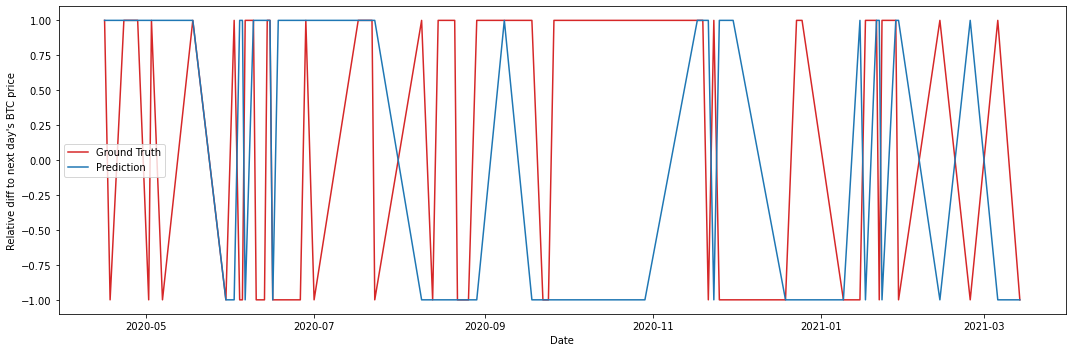

In [14]:
# Signed diff to next day's BTC price

x = X_test.Date
y_test = X_test['Close_diff_next1_sgn']
y_pred = X_test['Pred_diff_next1_sgn']

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Relative diff to next day\'s BTC price')
ax.plot(x, y_test, color='tab:red', label='Ground Truth')
ax.plot(x, y_pred, color='tab:blue', label='Prediction')

plt.legend()
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Feature importance

Importance type: weight
{'tw_neg_sum': 1863, 'tw_neg_mean': 1033, 'tw_neg_std': 759, 'tw_pos_std': 691, 'tw_pos_sum': 625, 'tw_pos_mean': 617, 'tw_Like_Count_mean': 561, 'tw_RelDiffPosNeg_sum': 530, 'tw_Reply_Count_mean': 520, 'tw_Like_Count_sum': 516, 'tw_Retweet_Count_mean': 511, 'tw_comp_sum': 479, 'tw_Quote_Count_sum': 479, 'tw_Like_Count_std': 463, 'tw_comp_std': 453, 'tw_comp_q3_count': 453, 'tw_RelDiffPosNeg_std': 449, 'tw_Retweet_Count_sum': 407, 'tw_Reply_Count_sum': 363, 'tw_comp_q4_count': 359, 'tw_Quote_Count_mean': 351, 'tw_Reply_Count_std': 327, 'tw_comp_mean': 326, 'tw_Retweet_Count_std': 318, 'tw_comp_q2_count': 317, 'tw_comp_q5_count': 315, 'tw_RelDiffPosNeg_mean': 280, 'tw_Quote_Count_std': 265, 'tw_comp_q1_count': 206, 'tw_N': 183, 'tw_N_neg': 172, 'tw_N_pos': 160, 'elonmusk': 25, 'MrBeast': 7, 'theestallion': 2}
Importance type: gain
{'tw_Like_Count_sum': 884207645.83, 'tw_comp_q1_count': 723545699.77, 'tw_N_pos': 363539438.43, 'tw_N': 353963374.88, 'tw_N_neg': 3252

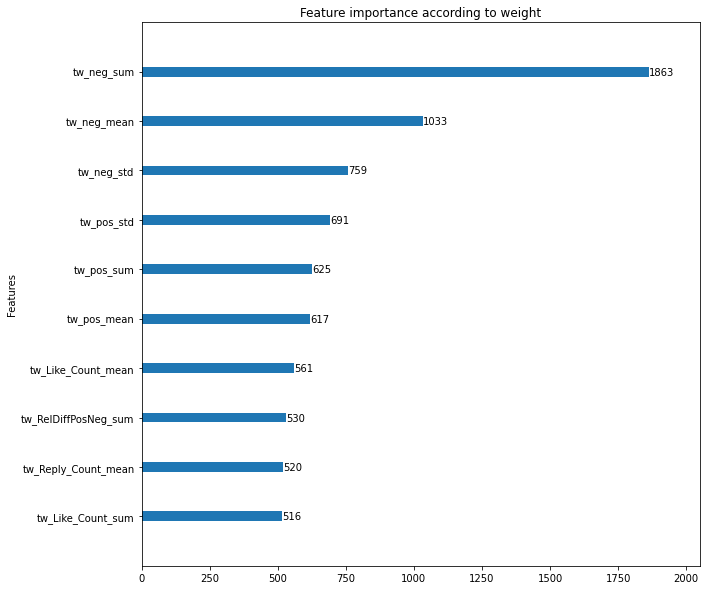

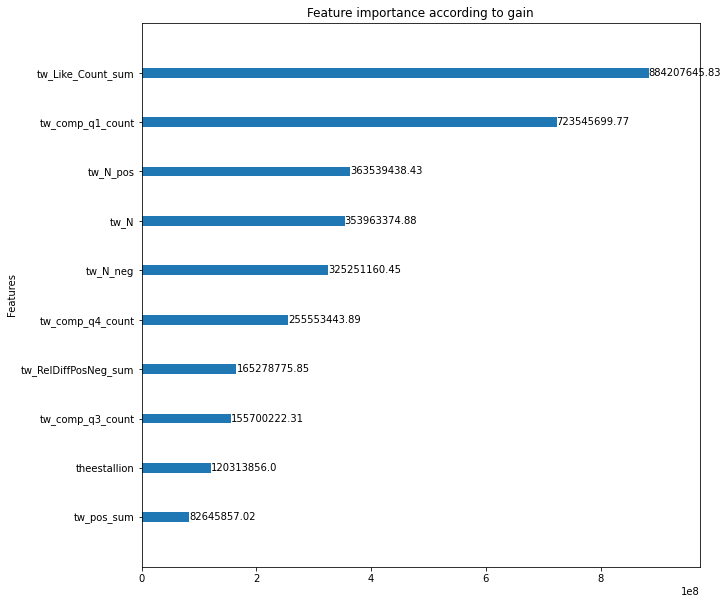

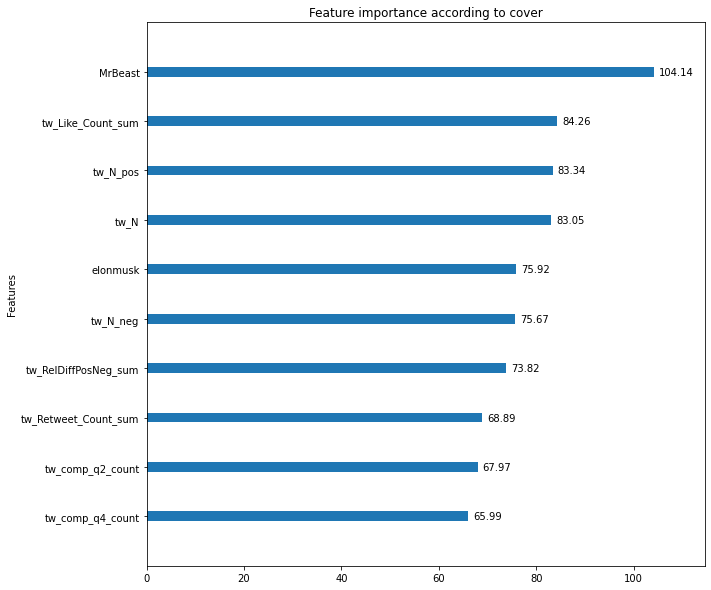

In [15]:
import operator

for importance_type in ['weight', 'gain', 'cover']:

    # Get the importance dictionary (by gain) from the booster
    importance = model.get_booster().get_score(importance_type=importance_type)

    # make your changes
    for key in importance.keys():
        importance[key] = round(importance[key],2)
        
    print('==============')
    print(f'Importance type: {importance_type}')
    print(dict(sorted(importance.items(),
                            key=operator.itemgetter(1),
                            reverse=True)))

    # provide the importance dictionary to the plotting function
    #ax = plot_importance(importance, max_num_features=3, importance_type='gain', show_values=True)

    # Plot variable importance
    ax = xgb.plot_importance(importance, max_num_features=10, grid=False, xlabel=None,\
                             title='Feature importance according to '+importance_type)
    fig = ax.figure
    fig.set_size_inches(10, 10)

## Target: Absolute difference to the next day's BTC Close price

### Prepare training and testing datasets

In [16]:
# Define target and input variables
target = 'Close_diff_next1'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [17]:
model = xgb.XGBRegressor(n_estimators = 1000,\
                        learning_rate = 0.01,\
                        max_depth = 5,\
                        min_split_loss = 10,\
                        min_child_weight = 1,\
                        colsample_bytree = 0.7,\
                        subsample = 0.5,\
                        reg_lambda = 2,\
                        reg_alpha = 0)

#model.fit(X_train_tmp.drop(columns=['Date']),y_train)
model.fit(X_train_tmp,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_split_loss=10, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=2,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Compute extra features for performance evaluation

In [18]:
y_pred=model.predict(X_test_tmp)

X_test['Pred_diff_next1'] = list(y_pred)
X_test['Pred_diff_next1_rel'] = (X_test.Pred_diff_next1/X_test.Close).to_list()
X_test['Pred_diff_next1_sgn'] = np.sign(X_test.Pred_diff_next1)

<ipython-input-18-b6d71e7a9ad9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1'] = list(y_pred)
<ipython-input-18-b6d71e7a9ad9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1_rel'] = (X_test.Pred_diff_next1/X_test.Close).to_list()
<ipython-input-18-b6d71e7a9ad9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

### Performance evaluation

In [19]:
print('==================================================================================')
print('Performance on the absolute diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1']
pred = X_test['Pred_diff_next1']
print('+++ Diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the relative diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_rel']
pred = X_test['Pred_diff_next1_rel']
print('+++ Relative diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_sgn']
pred = X_test['Pred_diff_next1_sgn']
print('+++ Next day BTC price')
print(f"Accuracy:    {accuracy_score(test, pred)}")

Performance on the absolute diff between today's and next day's BTC Close price
+++ Diff to next day BTC price
Explained variance:    -0.7901485696654691
R2:                    -0.8351518625416199
MAE:                   643.2330211321189
MSE:                   1467316.3840757401

Performance on the relative diff between today's and next day's BTC Close price
+++ Relative diff to next day BTC price
Explained variance:    -0.681769992483664
R2:                    -960.0764370086374
MAE:                   0.9943558532338957
MSE:                   0.9904767799727654

Performance on the signed diff between today's and next day's BTC Close price
+++ Next day BTC price
Accuracy:    0.5522388059701493


Importance type: weight
{'tw_neg_sum': 2294, 'tw_neg_mean': 1323, 'tw_neg_std': 1106, 'tw_pos_std': 747, 'tw_pos_sum': 735, 'tw_pos_mean': 727, 'tw_comp_std': 697, 'tw_RelDiffPosNeg_std': 689, 'tw_Like_Count_mean': 585, 'tw_comp_mean': 548, 'tw_comp_sum': 536, 'tw_comp_q3_count': 484, 'tw_Retweet_Count_mean': 480, 'tw_comp_q4_count': 478, 'tw_Reply_Count_mean': 477, 'tw_Quote_Count_mean': 453, 'tw_Like_Count_std': 446, 'tw_Reply_Count_sum': 426, 'tw_RelDiffPosNeg_sum': 421, 'tw_Retweet_Count_std': 409, 'tw_Reply_Count_std': 396, 'tw_Like_Count_sum': 382, 'tw_comp_q5_count': 364, 'tw_RelDiffPosNeg_mean': 361, 'tw_comp_q1_count': 349, 'tw_Quote_Count_std': 336, 'tw_Quote_Count_sum': 317, 'tw_N_neg': 293, 'tw_Retweet_Count_sum': 293, 'tw_comp_q2_count': 275, 'tw_N': 182, 'tw_N_pos': 130}
Importance type: gain
{'tw_comp_q4_count': 2654408.36, 'tw_N_neg': 2393025.48, 'tw_N': 2301994.67, 'tw_N_pos': 1818502.26, 'tw_comp_q1_count': 1795182.31, 'tw_comp_q2_count': 1701085.89, 'tw_comp_q5_count

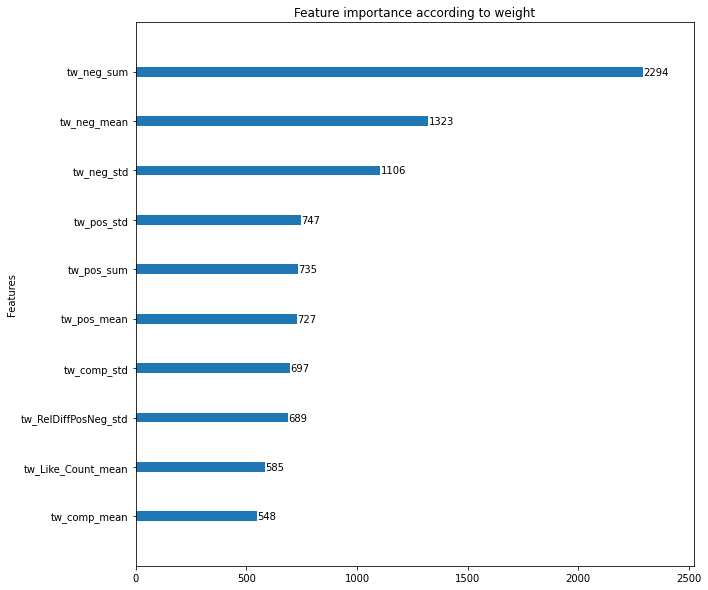

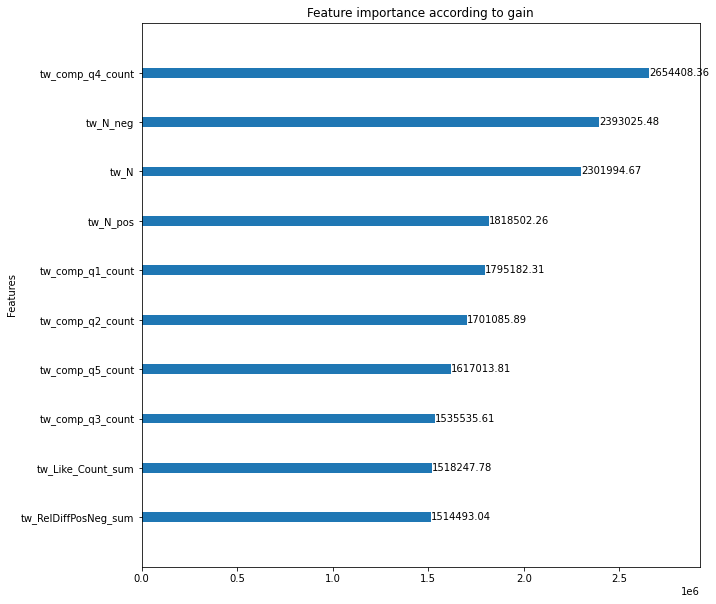

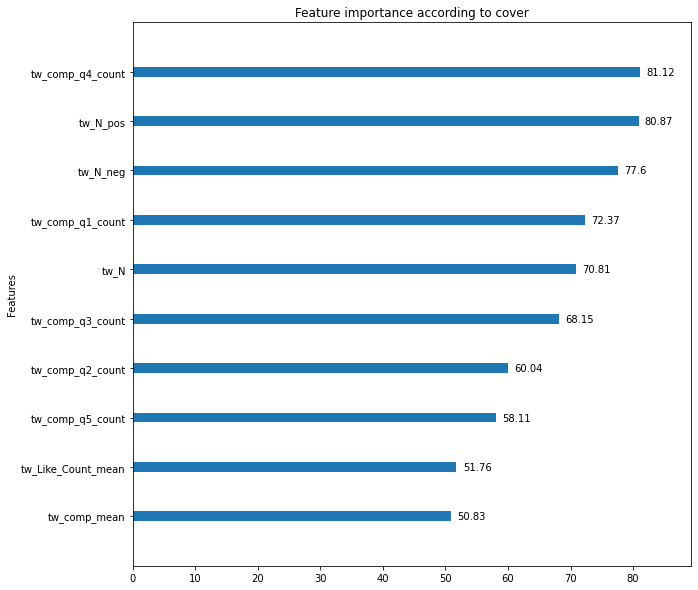

In [20]:
import operator

for importance_type in ['weight', 'gain', 'cover']:

    # Get the importance dictionary (by gain) from the booster
    importance = model.get_booster().get_score(importance_type=importance_type)

    # make your changes
    for key in importance.keys():
        importance[key] = round(importance[key],2)
        
    print('==============')
    print(f'Importance type: {importance_type}')
    print(dict(sorted(importance.items(),
                            key=operator.itemgetter(1),
                            reverse=True)))

    # provide the importance dictionary to the plotting function
    #ax = plot_importance(importance, max_num_features=3, importance_type='gain', show_values=True)

    # Plot variable importance
    ax = xgb.plot_importance(importance, max_num_features=10, grid=False, xlabel=None,\
                             title='Feature importance according to '+importance_type)
    fig = ax.figure
    fig.set_size_inches(10, 10)

## Target: Relative difference to the next day's BTC Close price

### Prepare training and testing datasets

In [25]:
# Define target and input variables
target = 'Close_diff_next1_rel'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [26]:
model = xgb.XGBRegressor(n_estimators = 1000,\
                        learning_rate = 0.01,\
                        max_depth = 5,\
                        min_split_loss = 10,\
                        min_child_weight = 1,\
                        colsample_bytree = 0.7,\
                        subsample = 0.5,\
                        reg_lambda = 2,\
                        reg_alpha = 0)

#model.fit(X_train_tmp.drop(columns=['Date']),y_train)
model.fit(X_train_tmp,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_split_loss=10, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=2,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Compute extra features for performance evaluation

In [27]:
y_pred=model.predict(X_test_tmp)

X_test['Pred_diff_next1'] = list(y_pred)
X_test['Pred_diff_next1_rel'] = list(y_pred)
X_test['Pred_diff_next1_sgn'] = np.sign(X_test.Pred_diff_next1_rel)

<ipython-input-27-86142636e4f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1'] = list(y_pred)
<ipython-input-27-86142636e4f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred_diff_next1_rel'] = list(y_pred)
<ipython-input-27-86142636e4f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

### Performance evaluation

In [28]:
print('==================================================================================')
print('Performance on the relative diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_rel']
pred = X_test['Pred_diff_next1_rel']
print('+++ Relative diff to next day BTC price')
print(f"Explained variance:    {explained_variance_score(test, pred)}")
print(f"R2:                    {r2_score(test, pred)}")
print(f"MAE:                   {mean_absolute_error(test, pred)}")
print(f"MSE:                   {mean_squared_error(test, pred)}")
print()

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
test = X_test['Close_diff_next1_sgn']
pred = X_test['Pred_diff_next1_sgn']
print('+++ Next day BTC price')
print(f"Accuracy:    {accuracy_score(test, pred)}")

Performance on the relative diff between today's and next day's BTC Close price
+++ Relative diff to next day BTC price
Explained variance:    2.220446049250313e-16
R2:                    -0.01599615010776767
MAE:                   0.021703514819490833
MSE:                   0.001047076545082776

Performance on the signed diff between today's and next day's BTC Close price
+++ Next day BTC price
Accuracy:    0.5671641791044776


## Target: Signed difference to the next day's BTC Close price

### Prepare training and testing datasets

In [29]:
# Define target and input variables
target = 'Close_diff_next1_sgn'
variables = df_ana.columns.to_list()

# Split
y = df_ana[target]
X = df_ana[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_test.sort_values(by=['Date'], inplace=True)

# Remove all variables derived from the BTC Close price
skip_pattern = 'Close'

X_train_tmp = X_train[X_train.columns.drop(list(X_train.filter(like=skip_pattern)))].copy(deep=True)
X_train_tmp.drop(columns=['Date'], inplace=True)

X_test_tmp = X_test[X_test.columns.drop(list(X_test.filter(like=skip_pattern)))].copy(deep=True)
X_test_tmp.drop(columns=['Date'], inplace=True)

### Prepare and train the model

In [30]:
imbalance = len(y_train)/sum(y_train)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20,\
                              random_state=42, eval_metric=["auc"],\
                             #scale_pos_weight=imbalance
                             )
#eval_metric=["auc", "error", "error@0.6"]

#xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
xgb_model.fit(X_train_tmp, y_train)

y_pred = xgb_model.predict(X_test_tmp)

/Users/snezana/testenv/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Performance evaluation

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

print('==================================================================================')
print('Performance on the signed diff between today\'s and next day\'s BTC Close price' )
print()
print('Accuracy:')
print(accuracy_score(y_test,y_pred))
print()
print('Confusion matrix:')
print(confusion_matrix(y_test,y_pred))
print()
print('Classification report:')
print(classification_report(y_test,y_pred))

Performance on the signed diff between today's and next day's BTC Close price

Accuracy:
0.5671641791044776

Confusion matrix:
[[13 16]
 [13 25]]

Classification report:
              precision    recall  f1-score   support

        -1.0       0.50      0.45      0.47        29
         1.0       0.61      0.66      0.63        38

    accuracy                           0.57        67
   macro avg       0.55      0.55      0.55        67
weighted avg       0.56      0.57      0.56        67

